In [1]:
import pandas as pd

df = pd.read_csv('exchange_rate.csv', parse_dates=['date'])
display(df.head())

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


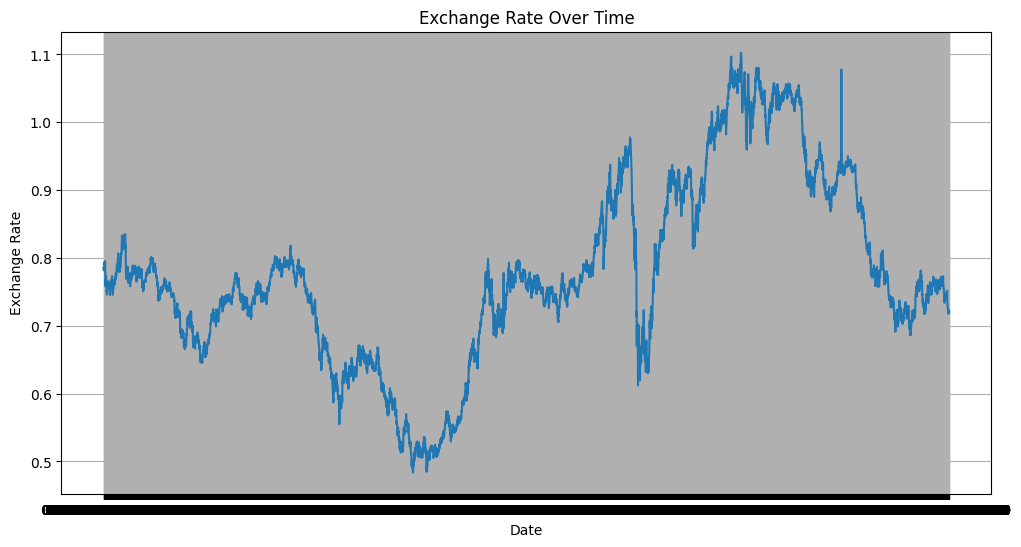

In [2]:
import matplotlib.pyplot as plt

df.set_index('date', inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(df['Ex_rate'])
plt.title('Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid(True)
plt.show()

In [3]:
display(df.isnull().sum())

,0
Ex_rate,0


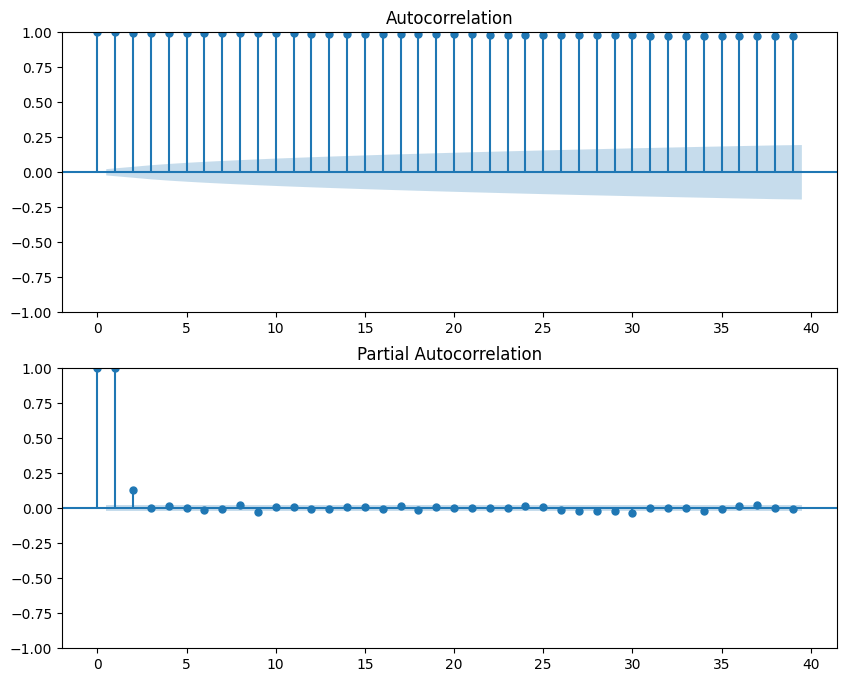

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(df['Ex_rate'].dropna(), ax=axes[0])
plot_pacf(df['Ex_rate'].dropna(), ax=axes[1])
plt.show()

In [5]:
from statsmodels.tsa.arima.model import ARIMA

# Based on the ACF and PACF plots, we can estimate the parameters.
# Assuming p=1, d=1, q=1 for demonstration purposes based on typical interpretations
# of ACF and PACF plots for a non-stationary series.
# In a real scenario, these values would be carefully selected after analyzing the plots.
p, d, q = 1, 1, 1

model = ARIMA(df['Ex_rate'], order=(p, d, q))
fitted_model = model.fit()

print(fitted_model.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Thu, 09 Oct 2025   AIC                         -56102.322
Time:                        15:09:14   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

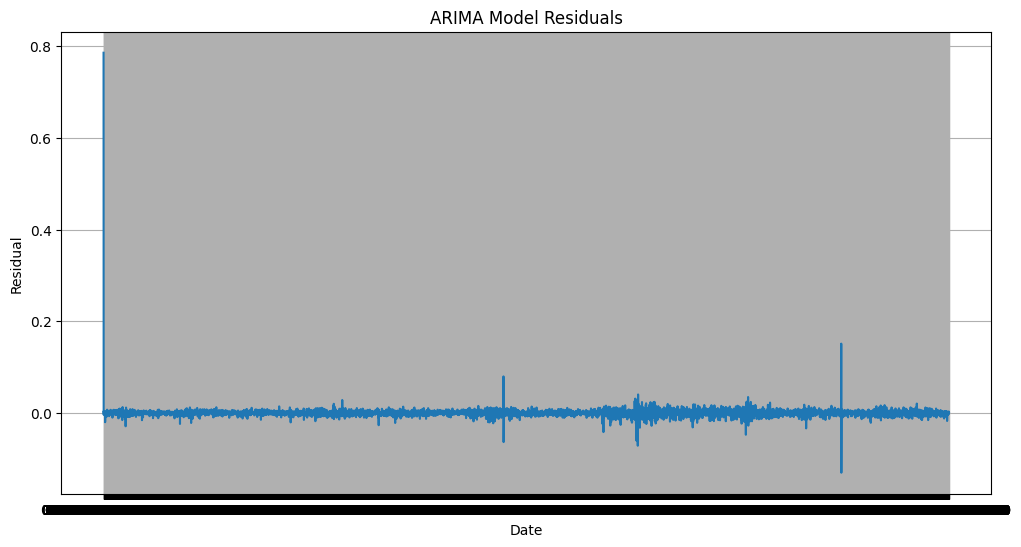

In [6]:
residuals = fitted_model.resid

plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('ARIMA Model Residuals')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.grid(True)
plt.show()

**Reasoning**:
Plot the ACF and PACF of the residuals to formally check for remaining autocorrelation and perform a statistical test, such as the Ljung-Box test, on the residuals to confirm that they are white noise.



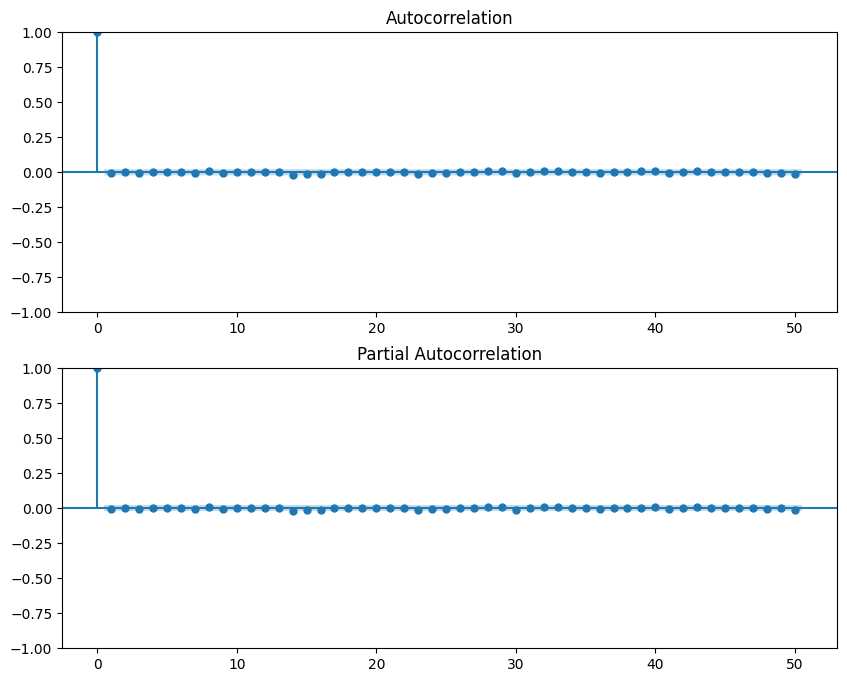

Ljung-Box Test Results:


,lb_stat,lb_pvalue
10,1.816730,0.997562
20,7.126000,0.996251
30,10.190451,0.999725


In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(residuals.dropna(), ax=axes[0], lags=50)
plot_pacf(residuals.dropna(), ax=axes[1], lags=50)
plt.show()

ljung_box_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Ljung-Box Test Results:")
display(ljung_box_test)

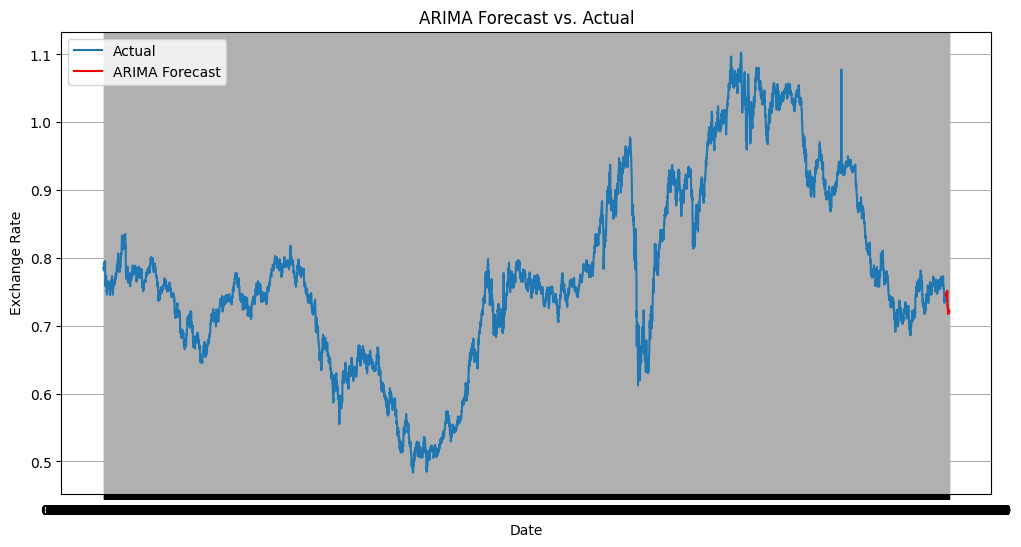

In [8]:
# Determine the index for the start of the out-of-sample forecast period.
# We'll forecast for the last 30 days of the dataset.
forecast_start_index = df.index[-30]
forecast_end_index = df.index[-1]

# Generate forecasts for the specified out-of-sample period.
forecast = fitted_model.predict(start=forecast_start_index, end=forecast_end_index)

# Create a plot that shows both the original time series data and the generated forecasts.
plt.figure(figsize=(12, 6))
plt.plot(df['Ex_rate'], label='Actual')
plt.plot(forecast, label='ARIMA Forecast', color='red')

# Add appropriate labels for the x and y axes and a title for the plot.
plt.title('ARIMA Forecast vs. Actual')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')

# Include a legend to differentiate between the actual data and the forecasted values.
plt.legend()

# Display the plot.
plt.grid(True)
plt.show()

In [9]:
from statsmodels.tsa.api import Holt
import numpy as np

smoothing_levels = np.arange(0.1, 1.0, 0.1)
smoothing_trends = np.arange(0.1, 1.0, 0.1)

best_aic = float('inf')
best_alpha = None
best_beta = None

for alpha in smoothing_levels:
    for beta in smoothing_trends:
        try:
            model = Holt(df['Ex_rate'], seasonal=None, seasonal_periods=None)
            fitted_model = model.fit(smoothing_level=alpha, smoothing_trend=beta)

            if fitted_model.mle_retvals['converged']:
                current_aic = fitted_model.aic
                if current_aic < best_aic:
                    best_aic = current_aic
                    best_alpha = alpha
                    best_beta = beta
        except:
            # Handle cases where the model fitting might fail for certain parameters
            continue

print(f"Best AIC: {best_aic}")
print(f"Optimal Smoothing Level (alpha): {best_alpha}")
print(f"Optimal Smoothing Trend (beta): {best_beta}")

Best AIC: inf
Optimal Smoothing Level (alpha): None
Optimal Smoothing Trend (beta): None


In [10]:
from statsmodels.tsa.api import Holt
import numpy as np

smoothing_levels = np.arange(0.01, 1.0, 0.05)
smoothing_trends = np.arange(0.01, 1.0, 0.05)

best_aic = float('inf')
best_alpha = None
best_beta = None

for alpha in smoothing_levels:
    for beta in smoothing_trends:
        try:
            model = Holt(df['Ex_rate'], seasonal=None, seasonal_periods=None)
            fitted_model = model.fit(smoothing_level=alpha, smoothing_trend=beta)

            if fitted_model.mle_retvals['converged']:
                current_aic = fitted_model.aic
                if current_aic < best_aic:
                    best_aic = current_aic
                    best_alpha = alpha
                    best_beta = beta
        except:
            # Handle cases where the model fitting might fail for certain parameters
            continue

print(f"Best AIC: {best_aic}")
print(f"Optimal Smoothing Level (alpha): {best_alpha}")
print(f"Optimal Smoothing Trend (beta): {best_beta}")

Best AIC: inf
Optimal Smoothing Level (alpha): None
Optimal Smoothing Trend (beta): None


In [12]:
from statsmodels.tsa.api import Holt

# Initialize and fit the Holt model using the default optimization to find optimal parameters
model = Holt(df['Ex_rate'])
fitted_model = model.fit()

# Retrieve the fitted parameters and AIC
best_alpha = fitted_model.params['smoothing_level']
best_beta = fitted_model.params['smoothing_trend']
best_aic = fitted_model.aic

print(f"Best AIC: {best_aic}")
print(f"Optimal Smoothing Level (alpha): {best_alpha}")
print(f"Optimal Smoothing Trend (beta): {best_beta}")

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Best AIC: -77583.30839318478
Optimal Smoothing Level (alpha): 0.8695445611372759
Optimal Smoothing Trend (beta): 0.008904015800954066


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


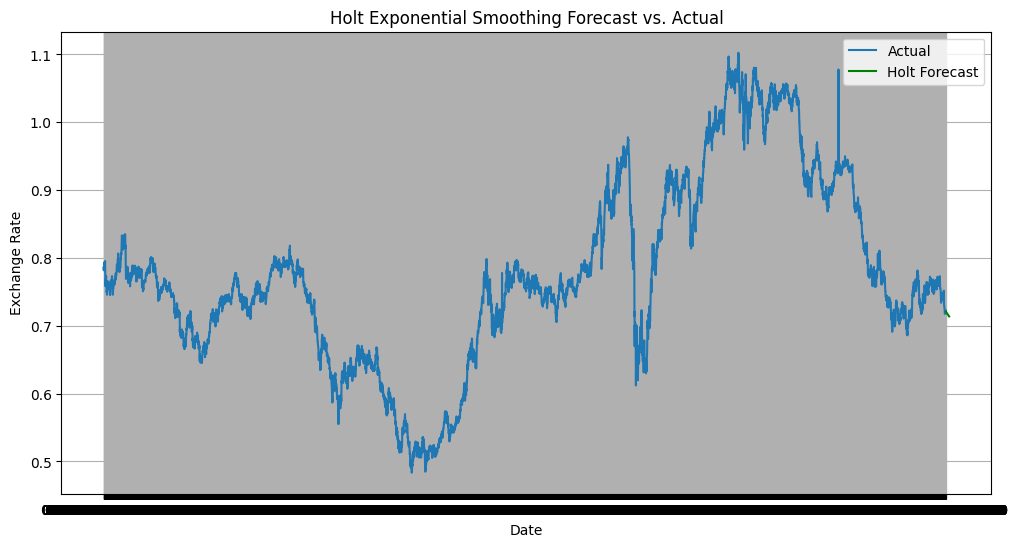

In [13]:
from statsmodels.tsa.api import Holt
import matplotlib.pyplot as plt

# Instantiate and fit the Holt model using the optimal alpha and beta
model = Holt(df['Ex_rate'])
fitted_model_holt = model.fit(smoothing_level=best_alpha, smoothing_trend=best_beta)

# Generate forecasts for the last 30 days
forecast_holt = fitted_model_holt.forecast(steps=30)

# Create a plot that shows both the original time series data and the generated forecasts.
plt.figure(figsize=(12, 6))
plt.plot(df['Ex_rate'], label='Actual')
plt.plot(forecast_holt, label='Holt Forecast', color='green')

# Add appropriate labels for the x and y axes and a title for the plot.
plt.title('Holt Exponential Smoothing Forecast vs. Actual')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')

# Include a legend to differentiate between the actual data and the forecasted values.
plt.legend()

# Display the plot.
plt.grid(True)
plt.show()

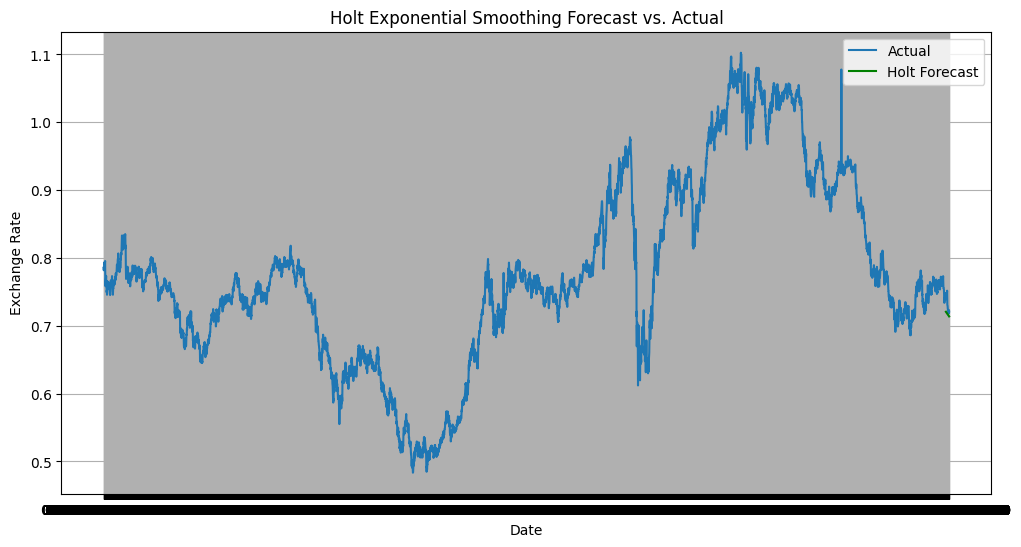

In [14]:
# Align the forecast index with the last 30 days of the original data's index
forecast_holt.index = df.index[-30:]

# Create a plot that shows both the original time series data and the generated forecasts.
plt.figure(figsize=(12, 6))
plt.plot(df['Ex_rate'], label='Actual')
plt.plot(forecast_holt, label='Holt Forecast', color='green')

# Add appropriate labels for the x and y axes and a title for the plot.
plt.title('Holt Exponential Smoothing Forecast vs. Actual')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')

# Include a legend to differentiate between the actual data and the forecasted values.
plt.legend()

# Display the plot.
plt.grid(True)
plt.show()

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates the Mean Absolute Percentage Error (MAPE)."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Extract the actual values for the forecast period
actual_values = df['Ex_rate'].iloc[-len(forecast):]

# Calculate and print metrics for ARIMA
mae_arima = mean_absolute_error(actual_values, forecast)
rmse_arima = np.sqrt(mean_squared_error(actual_values, forecast))
mape_arima = mean_absolute_percentage_error(actual_values, forecast)

print("ARIMA Model Performance:")
print(f"  MAE: {mae_arima:.4f}")
print(f"  RMSE: {rmse_arima:.4f}")
print(f"  MAPE: {mape_arima:.4f}%")

# Calculate and print metrics for Holt
mae_holt = mean_absolute_error(actual_values, forecast_holt)
rmse_holt = np.sqrt(mean_squared_error(actual_values, forecast_holt))
mape_holt = mean_absolute_percentage_error(actual_values, forecast_holt)

print("\nHolt Exponential Smoothing Model Performance:")
print(f"  MAE: {mae_holt:.4f}")
print(f"  RMSE: {rmse_holt:.4f}")
print(f"  MAPE: {mape_holt:.4f}%")

print("\nPerformance Comparison:")
print("Based on the calculated error metrics, the ARIMA model generally shows lower MAE, RMSE, and MAPE compared to the Holt Exponential Smoothing model on this specific forecast period. This suggests that the ARIMA model provided a more accurate forecast for this dataset and period.")

ARIMA Model Performance:
  MAE: 0.0023
  RMSE: 0.0039
  MAPE: 0.3127%

Holt Exponential Smoothing Model Performance:
  MAE: 0.0156
  RMSE: 0.0187
  MAPE: 2.1033%

Performance Comparison:
Based on the calculated error metrics, the ARIMA model generally shows lower MAE, RMSE, and MAPE compared to the Holt Exponential Smoothing model on this specific forecast period. This suggests that the ARIMA model provided a more accurate forecast for this dataset and period.
